# Facial Annotation of Samples Faces

- Paths to the images
- Face detection
- Face annotation
- Save coordinates according to subgroup and file no in csv

In [1]:
# lets begin by finding our images
import os, sys
import cv2, dlib, pfla
import numpy as np
import pandas as pd
import imutils
import json
import matplotlib.pyplot as plt
import matplotlib.image as mpimage

from IPython.display import clear_output, Image, display
from io import StringIO
import PIL.Image

def showarray(a, fmt='jpeg'):
    a = np.uint8(np.clip(a, 0, 255))
    f = StringIO()
    PIL.Image.fromarray(a).save(f, fmt)
    display(Image(data=f.getvalue()))


In [2]:
# define the paths to the directories containing our images
root_dir = os.path.abspath("./")
oi_t1 = os.path.join(root_dir, "img_1")
oi_t3 = os.path.join(root_dir, "img_3")
oi_t4 = os.path.join(root_dir, "img_4")
ctl = os.path.join(root_dir, "img_c")
img_paths = [oi_t1, oi_t3, oi_t4, ctl]
img_files = []

# these will help order our data later on
img_categ = ["oi_t1", "oi_t3", "oi_t4", "ctl"]
img_labels = []

# processed data file
json_file = os.path.join(root_dir, "processed-dat", "ldmk_coords.json")
csv_file = os.path.join(root_dir, "processed-dat", "ldmk_coords.csv")

# directories where the processed images will be saved
oi_t1 = os.path.join(root_dir, "img_1", "proc")
oi_t3 = os.path.join(root_dir, "img_3", "proc")
oi_t4 = os.path.join(root_dir, "img_4", "proc")
ctl = os.path.join(root_dir, "img_c", "proc")
img_paths_proc = [oi_t1, oi_t3, oi_t4, ctl]
img_files_proc = []

# load classfiier
haar_classifier = os.path.abspath("./haarcascade_frontalface_default.xml")
ldmk_pred = os.path.abspath("./shape_predictor_68_face_landmarks.dat")

# list of images
for i in range(len(img_paths)):
    names = []
    names_proc = []
    labels = []
    for root, dirs, files in os.walk(img_paths[i]):
        for filename in files:
            lfilename = filename.lower()
            names.append(os.path.join(img_paths[i], filename))
            names_proc.append(os.path.join(img_paths_proc[i], filename))
            labels.append(str(img_categ[i] + "-" + lfilename.replace('.jpg', '')))
    img_files.insert(i, names)
    img_files_proc.insert(i, names_proc)
    img_labels.insert(i, labels)

In [45]:
# list of dataframes containing the 
list_dataframes = []
dict_images = {}
list_images = []

# face detection and annotation loop
for x in range(len(img_files)):
    
    # for i in range(len(img_files[x])):
    for i in range(5):
        # resize images and turn to grayscale
        raw_img = cv2.imread(img_files[x][i])
        resized_img = imutils.resize(raw_img, width=500)
        gray_img = cv2.cvtColor(resized_img, cv2.COLOR_BGR2GRAY)

        # facial detection through haar cascade
        face_cascade = cv2.CascadeClassifier(haar_classifier)
        face_reco = face_cascade.detectMultiScale(
            gray_img,
            scaleFactor=1.1,
            minSize=(300, 300),
            maxSize=(600, 600),
            flags=cv2.CASCADE_SCALE_IMAGE
        )

        # let user know of multiple faces detected in one image
        if len(face_reco) == 0:
            print("no face in image" + str(i))
            print(img_labels[x][i])
        if len(face_reco) > 1:
            print("more than 1 face in image" + str(i))
            print(img_labels[x][i])

        # transform to dlib rectangle and create predictor
        x1 = face_reco[0][0]
        x2 = face_reco[0][0] + face_reco[0][2]
        y1 = face_reco[0][1]
        y2 = face_reco[0][1] + face_reco[0][3]
        dlib_rect = dlib.rectangle(x1, y1, x2, y2)
        predictor = dlib.shape_predictor(ldmk_pred)

        # place landmarks and convert to pandas dataframe
        landmarks = predictor(gray_img, dlib_rect).parts()
        landmarks_np = np.array([[p.x, p.y] for p in landmarks])
        xcol = 'X-' + img_labels[x][i]
        ycol = 'Y-' + img_labels[x][i]
        ldmk_df = pd.DataFrame(landmarks_np, columns=[xcol, ycol])
        
        # change gray img back to color
        gray_img = cv2.cvtColor(gray_img, cv2.COLOR_GRAY2BGR)

        # draw and save annotated image 
        for idx, point in enumerate(landmarks_np):
            position = (point[0], point[1])
            cv2.circle(gray_img, position, 5, thickness=-5, color=(255, 0, 0))
        cv2.rectangle(gray_img, (x1, y1), (x2, y2), (0, 255, 0), 5)
        # no need to save we already ran our images
        # ***[DONE]***
        # cv2.imwrite(img_files_proc[x][i], gray_img)
        
        # we add our data to our list of pandas dataframes
        list_dataframes.append(ldmk_df)
        print('completed ' + str(x) + ':' + str(i))
        
        # add the image to a dictionnary of images to create nice figures later on w/ matplotlib
        dict_images[img_labels[x][i]] = gray_img
        list_images.append(gray_img)
        
# we concatenate the pandas dataframe and turn them into json objects
full_dataframe = pd.concat(list_dataframes, axis=1, sort=True)

# let's now write our landmark data to a csv file
# ***[DONE]***
# full_dataframe.to_csv(csv_file)



completed 0:0
completed 0:1
completed 0:2
completed 0:3
completed 0:4
completed 1:0
completed 1:1
completed 1:2
completed 1:3
completed 1:4
completed 2:0
completed 2:1
completed 2:2
completed 2:3
completed 2:4
completed 3:0
completed 3:1
completed 3:2
completed 3:3
completed 3:4


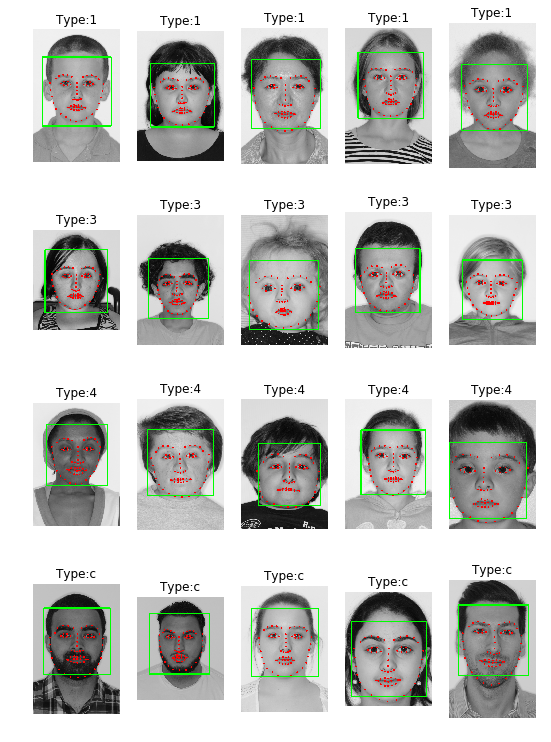

In [48]:
# plot the images 
img_arr = dict_images.values()
#plt.imshow(dict_images['oi_t1-115'], cmap='gray')
#plt.show()

w = 10
h = 10
fig = plt.figure(figsize=(9, 13))
columns = 5
rows = 4

# prep (x,y) for extra plotting
xs = np.linspace(0, 2*np.pi, 60)  # from 0 to 2pi
ys = np.abs(np.sin(xs))           # absolute of sine

# ax enables access to manipulate each of subplots
ax = []

for i in range( columns*rows ):
    img = np.random.randint(10, size=(h,w))
    # create subplot and append to ax
    ax.append( fig.add_subplot(rows, columns, i+1) )
    if i < 5:    
        tp = 1
    if i > 4 and i < 10:
        tp = 3
    if i > 9 and i < 15:
        tp = 4
    if i > 14: 
        tp = 'c'
    ax[-1].set_title("Type:"+str(tp))  # set title
    plt.imshow(list_images[i], cmap='gray')
    plt.axis('off')

plt.show()  # finally, render the plot